In [6]:
import open3d as o3d
import glob
from pydicom import dcmread
import os
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from rsna_dataloader import *

DATA_BASEPATH = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
TRAINING_DATA = retrieve_coordinate_training_data(DATA_BASEPATH)

df = TRAINING_DATA.dropna()
# This drops any subjects with nans

filtered_df = pd.DataFrame(columns=df.columns)
for series_desc in CONDITIONS.keys():
    subset = df[df['series_description'] == series_desc]
    if series_desc == "Sagittal T2/STIR":
        subset = subset[subset.groupby(["study_id"]).transform('size') == 5]
    else:
        subset = subset[subset.groupby(["study_id"]).transform('size') == 10]
    filtered_df = pd.concat([filtered_df, subset])

filtered_df = filtered_df[filtered_df.groupby(["study_id"]).transform('size') == 25]

series_descs = {e[0]: e[1] for e in df[["series_id", "series_description"]].drop_duplicates().values}

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [8]:
coords = pd.read_csv("../data/SpineNet/coords_3d.csv")
coords

,study_id,level,x,y,z
0,4003253,L1,2.192236,57.393290,-373.897314
1,4003253,L2,2.417129,55.910159,-405.982332
2,4003253,L3,2.663579,53.663727,-441.036977
3,4003253,L4,2.900401,54.755404,-475.276522
4,4003253,L5,-1.697765,63.999043,-505.892668
...,...,...,...,...,...
11844,4290709089,L2,1.119082,47.663407,-359.280225
11845,4290709089,L3,0.473506,40.302511,-394.637869
11846,4290709089,L4,-0.206997,39.813034,-429.821794
11847,4290709089,L5,-0.924925,46.765941,-464.796865


In [ ]:
bounding_boxes = pd.read_csv("../data/SpineNet/bounding_boxes_3d.csv")
bounding_boxes

In [ ]:
f, axs = plt.subplots(5, 3)

for i in range(5):
    row = bounding_boxes.iloc[i]
    level = row['level'].replace("/", "").lower()
    min_bound = np.array([row['x_min'], row['y_min'], row['z_min']])
    max_bound = np.array([row['x_max'], row['y_max'], row['z_max']])
    
    grid = read_vertebral_level_as_voxel_grid(
        f"../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/{row['study_id']}",
        vertebral_level=level,
        min_bound=min_bound,
        max_bound=max_bound,
        series_type_dict=series_descs,
        voxel_size=(128, 128, 128),
        caching=False)
    
    # grid = tf(grid.astype(np.float32))
    
    axs[i - 5, 0].imshow(np.max(grid[0, 62:66], axis=0), cmap="gray")
    axs[i - 5, 1].imshow(np.max(grid[0, :, 62:66], axis=1), cmap="gray")
    axs[i - 5, 2].imshow(np.max(grid[1, :, :, 62:66], axis=2), cmap="gray")
    
plt.show()

In [ ]:
def read_study_as_pcd(dir_path,
                      series_types_dict=None,
                      downsampling_factor=1,
                      resize_slices=True,
                      resize_method="nearest",
                      stack_slices_thickness=True,
                      img_size=(256, 256)):
    pcd_sagittal = o3d.geometry.PointCloud()
    pcd_axial = o3d.geometry.PointCloud()
    
    for path in glob.glob(os.path.join(dir_path, "**/*.dcm"), recursive=True):
        dicom_slice = dcmread(path)

        series_id = os.path.basename(os.path.dirname(path))
        study_id = os.path.basename(os.path.dirname(os.path.dirname(path)))
        if series_types_dict is None or int(series_id) not in series_types_dict:
            series_desc = dicom_slice.SeriesDescription
        else:
            series_desc = series_types_dict[int(series_id)]
            series_desc = series_desc.split(" ")[-1]

        x_orig, y_orig = dicom_slice.pixel_array.shape
        if resize_slices:
            if resize_method == "nearest":
                img = np.expand_dims(cv2.resize(dicom_slice.pixel_array, img_size, interpolation=cv2.INTER_AREA), -1)
            elif resize_method == "maxpool":
                img_tensor = torch.tensor(dicom_slice.pixel_array).float()
                img = F.adaptive_max_pool2d(img_tensor.unsqueeze(0), img_size).numpy()
            else:
                raise ValueError(f"Invalid resize_method {resize_method}")
        else:
            img = np.expand_dims(np.array(dicom_slice.pixel_array), -1)
        x, y, z = np.where(img)

        downsampling_factor_iter = max(downsampling_factor, int(math.ceil(len(x) / 6e6)))

        index_voxel = np.vstack((x, y, z))[:, ::downsampling_factor_iter]
        grid_index_array = index_voxel.T
        pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(grid_index_array.astype(np.float64)))

        vals = np.expand_dims(img[x, y, z][::downsampling_factor_iter], -1)
        if series_desc == "T1":
            vals = np.pad(vals, ((0, 0), (0, 2)))
        elif series_desc == "T2":
            vals = np.pad(vals, ((0, 0), (1, 1)))
        elif series_desc == "T2/STIR":
            vals = np.pad(vals, ((0, 0), (2, 0)))
        else:
            raise ValueError(f"Unknown series desc: {series_desc}")

        pcd.colors = o3d.utility.Vector3dVector(vals.astype(np.float64))

        if resize_slices:
            transform_matrix_factor = np.matrix(
                [[0, y_orig / img_size[1], 0, 0],
                 [x_orig / img_size[0], 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]]
            )
        else:
            transform_matrix_factor = np.matrix(
                [[0, 1, 0, 0],
                 [1, 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]]
            )

        dX, dY = dicom_slice.PixelSpacing
        dZ = dicom_slice.SliceThickness

        X = np.array(list(dicom_slice.ImageOrientationPatient[:3]) + [0]) * dX
        Y = np.array(list(dicom_slice.ImageOrientationPatient[3:]) + [0]) * dY

        S = np.array(list(dicom_slice.ImagePositionPatient) + [1])

        transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
        transform_matrix = transform_matrix @ transform_matrix_factor

        if stack_slices_thickness:
            for z in range(int(dZ) + 1):
                pos = list(dicom_slice.ImagePositionPatient)
                if series_desc == "T2":
                    pos[-1] += z
                else:
                    pos[0] += z
                S = np.array(pos + [1])

                transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
                transform_matrix = transform_matrix @ transform_matrix_factor

                if series_desc == "T2":
                    pcd_axial += copy.deepcopy(pcd).transform(transform_matrix)
                else:
                    pcd_sagittal += copy.deepcopy(pcd).transform(transform_matrix)

        else:
            if series_desc == "T2":
                pcd_axial += copy.deepcopy(pcd).transform(transform_matrix)
            else:
                pcd_sagittal += copy.deepcopy(pcd).transform(transform_matrix)

    bbox = pcd_sagittal.get_oriented_bounding_box()
    pcd_axial = pcd_axial.crop(bbox)

    return pcd_axial + pcd_sagittal


In [ ]:
def read_vertebral_level_as_voxel_grid(dir_path,
                                       vertebral_level: str,
                                       max_bound: np.array,
                                       min_bound: np.array,
                                       pcd_overall: o3d.geometry.PointCloud = None,
                                       series_type_dict=None,
                                       downsampling_factor=1,
                                       voxel_size=(128, 128, 32),
                                       caching=True,
                                       ):
    cache_path = os.path.join(dir_path, f"cached_grid_alt_{vertebral_level}_{voxel_size[0]}_{voxel_size[1]}_{voxel_size[2]}.npy.gz")
    f = None
    if caching and os.path.exists(cache_path):
        try:
            f = pgzip.PgzipFile(cache_path, "r")
            ret = np.load(f, allow_pickle=True)
            f.close()
            return ret
        except Exception as e:
            print(dir_path, "\n", e)
            if f:
                f.close()
            os.remove(cache_path)
    
    tf = tio.Resize(voxel_size)
    
    if pcd_overall is None:
        pcd_overall = read_study_as_pcd(dir_path,
                                        series_types_dict=series_type_dict,
                                        downsampling_factor=downsampling_factor,
                                        img_size=(voxel_size[0], voxel_size[1]),
                                        stack_slices_thickness=True,
                                        resize_slices=False)

    bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=min_bound, max_bound=max_bound)
    pcd_level = pcd_overall.crop(bbox)
        
    size = 1
    voxel_level = o3d.geometry.VoxelGrid().create_from_point_cloud(pcd_level, size, color_mode=o3d.geometry.VoxelGrid.VoxelColorMode.MAX)
            
    coords = np.array([voxel.grid_index for voxel in voxel_level.get_voxels()])    
    vals = np.array([voxel.color for voxel in voxel_level.get_voxels()], dtype=np.float16)
    
    size = np.max(coords, axis=0) + 1
    grid = np.zeros((3, size[0], size[1], size[2]), dtype=np.float32)
    indices = coords[:, 0], coords[:, 1], coords[:, 2]
    
    for i in range(3):
        grid[i][indices] = vals[:, i]
        
    grid = tf(grid)
    
    if caching:
        f = pgzip.PgzipFile(cache_path, "w")
        np.save(f, grid)
        f.close()

    return grid

In [ ]:
f, axs = plt.subplots(5, 3)

index = 12

for i in range(index * 5, (index + 1) * 5):
    row = bounding_boxes.iloc[i]
    level = row['level'].replace("/", "").lower()
    min_bound = np.array([row['x_min'], row['y_min'], row['z_min']])
    max_bound = np.array([row['x_max'], row['y_max'], row['z_max']])
    
    grid = read_vertebral_level_as_voxel_grid(
        f"../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/{row['study_id']}",
        vertebral_level=level,
        min_bound=min_bound,
        max_bound=max_bound,
        series_type_dict=series_descs,
        voxel_size=(160, 160, 160),
        caching=False)
    
    # grid = tf(grid.astype(np.float32))
    
    axs[i % 5, 0].imshow(grid[0, 16], cmap="gray")
    axs[i % 5, 1].imshow(grid[0, :, 16], cmap="gray")
    axs[i % 5, 2].imshow(grid[1, :, :, 16], cmap="gray")
    
plt.show()

In [ ]:
plt.imshow(grid[0, 40], cmap="gray")

In [22]:
def read_vertebral_level_as_voxel_grid_plane(dir_path,
                                               center_point_pair = tuple,
                                               pcd_overall: o3d.geometry.PointCloud = None,
                                               series_type_dict=None,
                                               downsampling_factor=1,
                                               voxel_size=(128, 128, 32),
                                            ):
    resize = tio.Resize(voxel_size)

    if pcd_overall is None:
        pcd_overall = read_study_as_pcd(dir_path,
                                        series_types_dict=series_type_dict,
                                        downsampling_factor=downsampling_factor,
                                        img_size=(voxel_size[0] * 2, voxel_size[1] * 2),
                                        stack_slices_thickness=True,
                                        resize_slices=False)
    
    min_bound = center_point_pair[1] - 25
    max_bound = center_point_pair[0] + 25
    
    bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=min_bound, max_bound=max_bound)
    pcd_overall = pcd_overall.crop(bbox)
    
    pts = np.array(pcd_overall.points)
    vals = np.array(pcd_overall.colors)

    dist_vec = center_point_pair[1] - center_point_pair[0]

    plane_1 = np.sum((pts-center_point_pair[0]) * dist_vec, axis=-1)
    plane_2 = np.sum((pts-center_point_pair[1]) * dist_vec, axis=-1)

    in_bounds = (plane_1 > 0) & (plane_2 < 0)
    
    pts_level = pts[in_bounds]
    vals_level = vals[in_bounds]

    pcd_level = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pts_level))
    pcd_level.colors = o3d.utility.Vector3dVector(vals_level)

    size = 1
    voxel_level = o3d.geometry.VoxelGrid().create_from_point_cloud(pcd_level, size,)
                                                                   # color_mode=o3d.geometry.VoxelGrid.VoxelColorMode.MAX)


    coords = np.array([voxel.grid_index for voxel in voxel_level.get_voxels()])
    vals = np.array([voxel.color for voxel in voxel_level.get_voxels()], dtype=np.float16)

    size = np.max(coords, axis=0) + 1
    grid = np.zeros((3, size[0], size[1], size[2]), dtype=np.float32)
    indices = coords[:, 0], coords[:, 1], coords[:, 2]

    for i in range(3):
        grid[i][indices] = vals[:, i]

    grid = resize(grid)

    return grid


In [23]:
coords = [[4003253,"L1",2.192236,57.393290,-373.897314],
[4003253,"L2",2.417129,55.910159,-405.982332],
[4003253,"L3",2.663579,53.663727,-441.036977],
[4003253,"L4",2.900401,54.755404,-475.276522],
[4003253,"L5",-1.697765,63.999043,-505.892668],
[4003253,"S1",-2.197765,72.999043,-525.892668]]

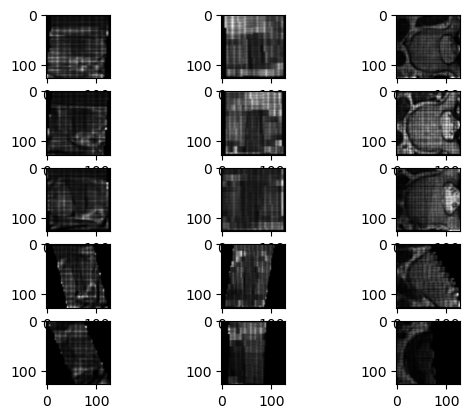

In [24]:
f, axs = plt.subplots(5, 3)

for i in range(5):
    row_1 = coords[i]
    row_2 = coords[i + 1]

    #level = (row_1['level'].str + "_" + row_2["level"].str).lower()
    pt1 = np.array([row_1[2], row_1[3], row_1[4]])
    pt2 = np.array([row_2[2], row_2[3], row_2[4]])
    
    grid = read_vertebral_level_as_voxel_grid_plane(
        f"../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/{row_1[0]}",
        center_point_pair=(pt1,pt2),
        series_type_dict=series_descs,
        voxel_size=(128, 128, 128)
    )
    
    # grid = tf(grid.astype(np.float32))
    
    axs[i % 5, 0].imshow(grid[0, 32], cmap="gray")
    axs[i % 5, 1].imshow(grid[0, :, 32], cmap="gray")
    axs[i % 5, 2].imshow(grid[1, :, :, 32], cmap="gray")
    
plt.show()